# LSTM时间序列预测深度实战

时间序列预测是机器学习中最实用的技能之一，应用广泛：
- **金融领域**：股票价格、汇率预测
- **气象预报**：温度、降雨量预测  
- **工业监控**：设备状态、能耗预测
- **零售业**：销量、库存需求预测
- **交通管理**：流量、拥堵预测

**为什么选择LSTM？**
- 能够学习长期依赖关系
- 处理非线性时间模式
- 对噪声有一定的鲁棒性
- 可以处理多变量输入

下面，我们以最经典的航班乘客流量预测作为例子，学习如何使用PyTorch实现时间序列的预测。

In [2]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

# 设置绘图样式
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

print("✅ 环境准备完成")
print("PyTorch版本:", torch.__version__)
print("CUDA可用:", torch.cuda.is_available())

✅ 环境准备完成
PyTorch版本: 2.5.1
CUDA可用: False


In [3]:
## 数据加载与探索性分析

# 读取航班乘客数据
try:
    data_csv = pd.read_csv('./data.csv', usecols=[1])
    print("✅ 数据加载成功")
except FileNotFoundError:
    print("⚠️ 未找到data.csv，创建模拟数据")
    # 创建模拟的航班乘客数据
    dates = pd.date_range('1949-01', '1960-12', freq='M')
    base_trend = np.linspace(100, 600, len(dates))
    seasonal = 50 * np.sin(2 * np.pi * np.arange(len(dates)) / 12)
    noise = np.random.normal(0, 20, len(dates))
    passenger_data = base_trend + seasonal + noise
    
    data_csv = pd.DataFrame(passenger_data, columns=['Passengers'])
    data_csv.to_csv('./data.csv', index=False)

print("数据基本信息:")
print("数据形状:", data_csv.shape)
print("数据类型:", data_csv.dtypes)
print("\n前5行数据:")
print(data_csv.head())

# 检查缺失值
print("\n缺失值检查:")
print(data_csv.isnull().sum())

# 基本统计信息
print("\n描述性统计:")
print(data_csv.describe())

✅ 数据加载成功
数据基本信息:
数据形状: (145, 1)
数据类型: International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60    float64
dtype: object

前5行数据:
   International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0                                              112.0                             
1                                              118.0                             
2                                              132.0                             
3                                              129.0                             
4                                              121.0                             

缺失值检查:
International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60    1
dtype: int64

描述性统计:
       International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
count                                         144.000000                             
mean                                          280.298611                 

In [5]:
data_csv = pd.read_csv('./data.csv', usecols=[1])

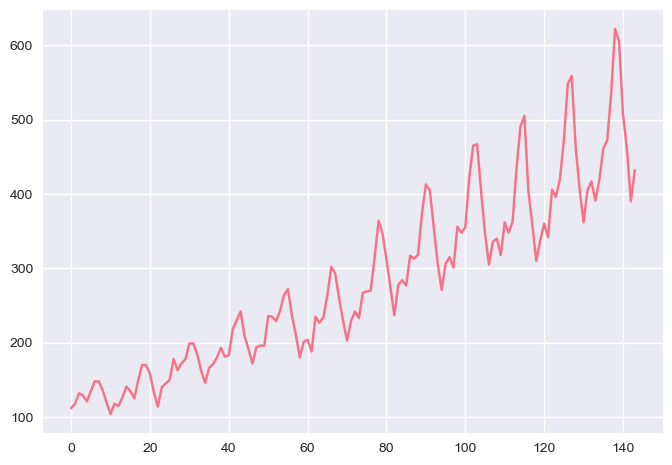

In [6]:
plt.plot(data_csv)

首先我们进行预处理，将数据中 `na` 的数据去掉，然后将数据标准化到 0 ~ 1 之间。

In [7]:
# 数据预处理
data_csv = data_csv.dropna()
dataset = data_csv.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset))

接着我们进行数据集的创建，我们想通过前面几个月的流量来预测当月的流量，比如我们希望通过前两个月的流量来预测当月的流量，我们可以将前两个月的流量当做输入，当月的流量当做输出。同时我们需要将我们的数据集分为训练集和测试集，通过测试集的效果来测试模型的性能，这里我们简单的将前面几年的数据作为训练集，后面两年的数据作为测试集。

In [8]:
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [9]:
# 创建好输入输出
data_X, data_Y = create_dataset(dataset)

In [10]:
# 划分训练集和测试集，70% 作为训练集
train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

In [11]:
train_Y.shape

(99, 1)

最后，我们需要将数据改变一下形状，因为 RNN 读入的数据维度是 (seq, batch, feature)，所以要重新改变一下数据的维度，这里只有一个序列，所以 batch 是 1，而输入的 feature 就是我们希望依据的几个月份，这里我们定的是两个月份，所以 feature 就是 2.

In [12]:
import torch

train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)

In [13]:
from torch import nn
from torch.autograd import Variable

这里定义好模型，模型的第一部分是一个两层的 RNN，每一步模型接受两个月的输入作为特征，得到一个输出特征。接着通过一个线性层将 RNN 的输出回归到流量的具体数值，这里我们需要用 `view` 来重新排列，因为 `nn.Linear` 不接受三维的输入，所以我们先将前两维合并在一起，然后经过线性层之后再将其分开，最后输出结果。

In [14]:
# 定义模型
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # 回归
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # 转换成线性层的输入格式
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [15]:
net = lstm_reg(2, 4)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

定义好网络结构，输入的维度是 2，因为我们使用两个月的流量作为输入，隐藏层的维度可以任意指定，这里我们选的 4

In [17]:
# 开始训练
for e in range(1000):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    # 前向传播
    out = net(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

Epoch: 100, Loss: 0.00888
Epoch: 200, Loss: 0.00431
Epoch: 300, Loss: 0.00361
Epoch: 400, Loss: 0.00279
Epoch: 500, Loss: 0.00209
Epoch: 600, Loss: 0.00170
Epoch: 700, Loss: 0.00156
Epoch: 800, Loss: 0.00150
Epoch: 900, Loss: 0.00147
Epoch: 1000, Loss: 0.00146


训练完成之后，我们可以用训练好的模型去预测后面的结果

In [18]:
net = net.eval() # 转换成测试模式

In [19]:
data_X = data_X.reshape(-1, 1, 2)
data_X = torch.from_numpy(data_X)
var_data = Variable(data_X)
pred_test = net(var_data) # 测试集的预测结果

In [20]:
# 改变输出的格式
pred_test = pred_test.view(-1).data.numpy()

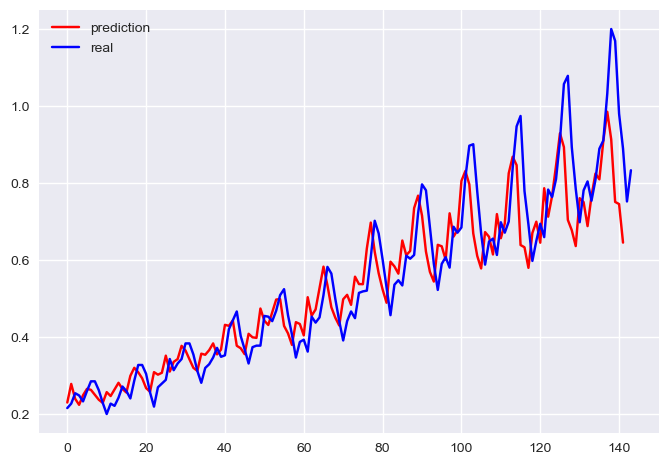

In [21]:
# 画出实际结果和预测的结果
plt.plot(pred_test, 'r', label='prediction')
plt.plot(dataset, 'b', label='real')
plt.legend(loc='best')

这里蓝色的是真实的数据集，红色的是预测的结果，我们能够看到，使用 lstm 能够得到比较相近的结果，预测的趋势也与真实的数据集是相同的，因为其能够记忆之前的信息，而单纯的使用线性回归并不能得到较好的结果，从这个例子也说明了 RNN 对于序列有着非常好的性能。

## 练习
* 试试改变隐藏状态输出的特征数，看看有没有什么改变，同时试试使用简单的线性回归模型，看看会得到什么样的结果